## Install

In [1]:
!!python -m pip install -r requirements.txt

['Requirement already satisfied: scikit-learn in c:\\users\\rapha\\appdata\\local\\programs\\python\\python310\\lib\\site-packages (from -r requirements.txt (line 1)) (1.2.2)',
 'Requirement already satisfied: matplotlib in c:\\users\\rapha\\appdata\\local\\programs\\python\\python310\\lib\\site-packages (from -r requirements.txt (line 2)) (3.6.2)',
 'Requirement already satisfied: numpy in c:\\users\\rapha\\appdata\\local\\programs\\python\\python310\\lib\\site-packages (from -r requirements.txt (line 3)) (1.24.2)',
 'Requirement already satisfied: pandas in c:\\users\\rapha\\appdata\\local\\programs\\python\\python310\\lib\\site-packages (from -r requirements.txt (line 4)) (1.4.2)',
 'Requirement already satisfied: riotwatcher in c:\\users\\rapha\\appdata\\local\\programs\\python\\python310\\lib\\site-packages (from -r requirements.txt (line 5)) (3.2.4)',
 'Requirement already satisfied: joblib>=1.1.1 in c:\\users\\rapha\\appdata\\local\\programs\\python\\python310\\lib\\site-package

## Imports

In [2]:
from collections import defaultdict, Counter
import itertools
import json
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# plt.style.use('dark_background')
plt.style.use('default')

## Load data

In [3]:
champions_names = json.load(open("data/champion.json", encoding="utf8"))
champions_names = {v["key"]: v["name"] for k, v in champions_names["data"].items()}
print(champions_names)

{'266': 'Aatrox', '103': 'Ahri', '84': 'Akali', '166': 'Akshan', '12': 'Alistar', '32': 'Amumu', '34': 'Anivia', '1': 'Annie', '523': 'Aphelios', '22': 'Ashe', '136': 'Aurelion Sol', '268': 'Azir', '432': 'Bard', '200': "Bel'Veth", '53': 'Blitzcrank', '63': 'Brand', '201': 'Braum', '51': 'Caitlyn', '164': 'Camille', '69': 'Cassiopeia', '31': "Cho'Gath", '42': 'Corki', '122': 'Darius', '131': 'Diana', '119': 'Draven', '36': 'Dr. Mundo', '245': 'Ekko', '60': 'Elise', '28': 'Evelynn', '81': 'Ezreal', '9': 'Fiddlesticks', '114': 'Fiora', '105': 'Fizz', '3': 'Galio', '41': 'Gangplank', '86': 'Garen', '150': 'Gnar', '79': 'Gragas', '104': 'Graves', '887': 'Gwen', '120': 'Hecarim', '74': 'Heimerdinger', '420': 'Illaoi', '39': 'Irelia', '427': 'Ivern', '40': 'Janna', '59': 'Jarvan IV', '24': 'Jax', '126': 'Jayce', '202': 'Jhin', '222': 'Jinx', '145': "Kai'Sa", '429': 'Kalista', '43': 'Karma', '30': 'Karthus', '38': 'Kassadin', '55': 'Katarina', '10': 'Kayle', '141': 'Kayn', '85': 'Kennen', '12

In [4]:
matches = json.load(open("data/matches.json"))

In [15]:
champions_games = []
versions = []

for match in matches:
    if match["info"]["gameVersion"] != "13.5.495.8836":
        continue

    champs_w = []
    champs_l = []
    champions_games.append(champs_w)
    champions_games.append(champs_l)

    for participant in match["info"]["participants"]:
        if participant["win"]:
            champs_w.append(participant["championId"])
        else:
            champs_l.append(participant["championId"])

    versions.append(match["info"]["gameVersion"])

champions_games = np.array(champions_games)
print(champions_games.shape)
print(Counter(versions))
print(Counter({champions_names[str(k)]:v for k, v in dict(Counter(champions_games.reshape(-1,))).items()}))

(72804, 5)
Counter({'13.5.495.8836': 36402})
Counter({'Jinx': 7304, 'Lux': 6859, "Kai'Sa": 6303, 'Caitlyn': 6206, 'Miss Fortune': 5846, 'Ezreal': 5823, 'Thresh': 5544, 'Veigar': 5538, 'Xayah': 5275, 'Jarvan IV': 5230, 'Jhin': 4812, 'Yuumi': 4807, 'Senna': 4769, 'Tristana': 4344, 'Zed': 4021, 'Kayn': 4016, 'Aurelion Sol': 3996, 'Yasuo': 3978, 'Lee Sin': 3963, 'Annie': 3733, 'Sylas': 3716, 'Ashe': 3689, 'Malphite': 3633, 'Yone': 3587, 'Jax': 3578, 'Twitch': 3443, 'Darius': 3435, 'Vi': 3381, 'Rakan': 3346, 'Mordekaiser': 3342, 'Diana': 3341, 'Nautilus': 3193, 'Wukong': 3187, 'Gragas': 3158, 'Ekko': 3156, 'Garen': 3058, 'Katarina': 2971, 'Morgana': 2970, 'Varus': 2956, 'Zeri': 2950, 'Shaco': 2921, 'Nocturne': 2862, 'Amumu': 2843, 'Pantheon': 2822, 'Sion': 2818, 'Master Yi': 2796, 'Ahri': 2783, 'Lulu': 2780, 'Gangplank': 2765, 'Samira': 2732, 'Viego': 2704, "Cho'Gath": 2690, 'Olaf': 2649, 'Warwick': 2642, 'Riven': 2633, 'Irelia': 2617, 'Fizz': 2576, 'Akali': 2557, 'Sett': 2517, 'Nami': 2489

## Transform the data

In [16]:
champion_ids = np.unique(champions_games)
champion_column = {champion_id: i for i, champion_id in enumerate(champion_ids)}

X = np.zeros((len(champion_ids), len(champion_ids)))
labels = [champions_names[str(id_)] for id_ in champion_ids]

for comp in champions_games:                        
    for x, y in itertools.permutations(comp, 2):
        cx = champion_column[x]
        cy = champion_column[y]
        X[cx, cy] += 1

# normalize
# X /= len(list(itertools.permutations(comp, 2))) / len(comp)
X = X / np.sqrt((X**2).sum(axis=0))[:,None]

## Visualize the transformed data

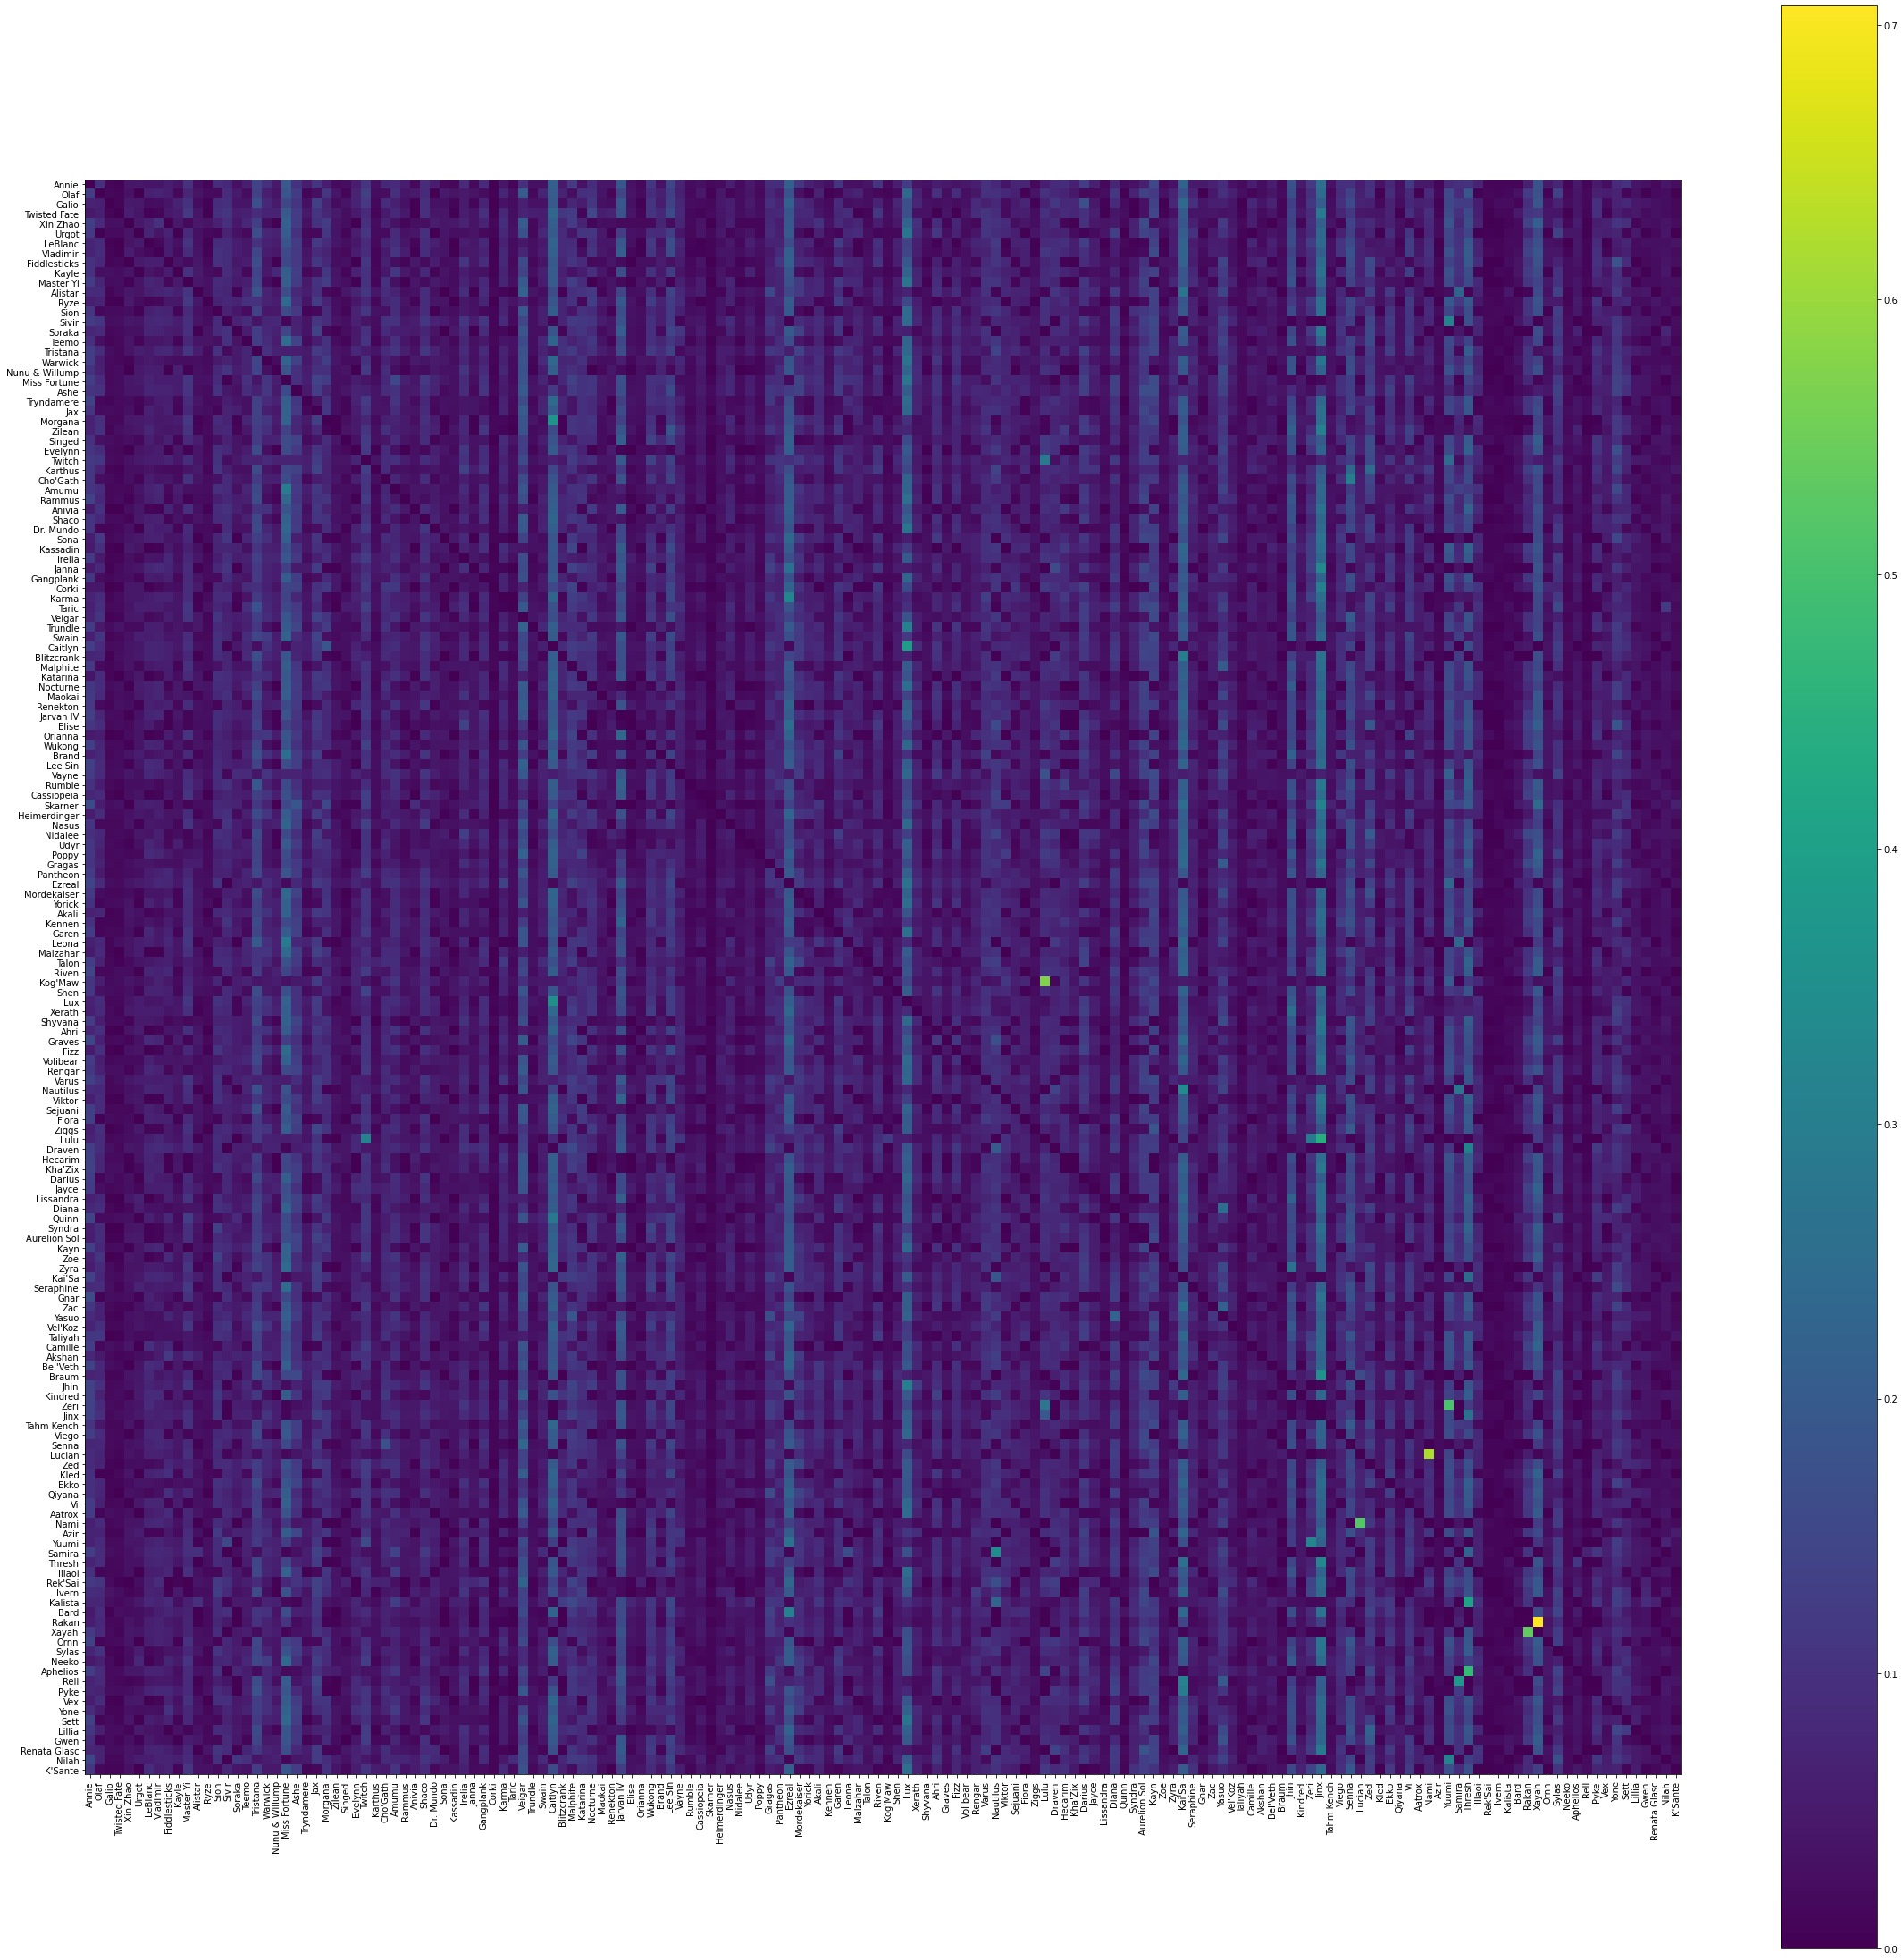

In [17]:
df = pd.DataFrame(X)
a = plt.figure(figsize=(40, 40))
plt.imshow(df)
ticks = (range(X.shape[0]), labels)
plt.yticks(*ticks, rotation=0)
plt.xticks(*ticks, rotation=90)
cb = plt.colorbar()

## Clustering

In [18]:
clustering = KMeans(n_clusters=champions_games.shape[1], n_init=20, max_iter=500).fit(X)

## Clusters visualization

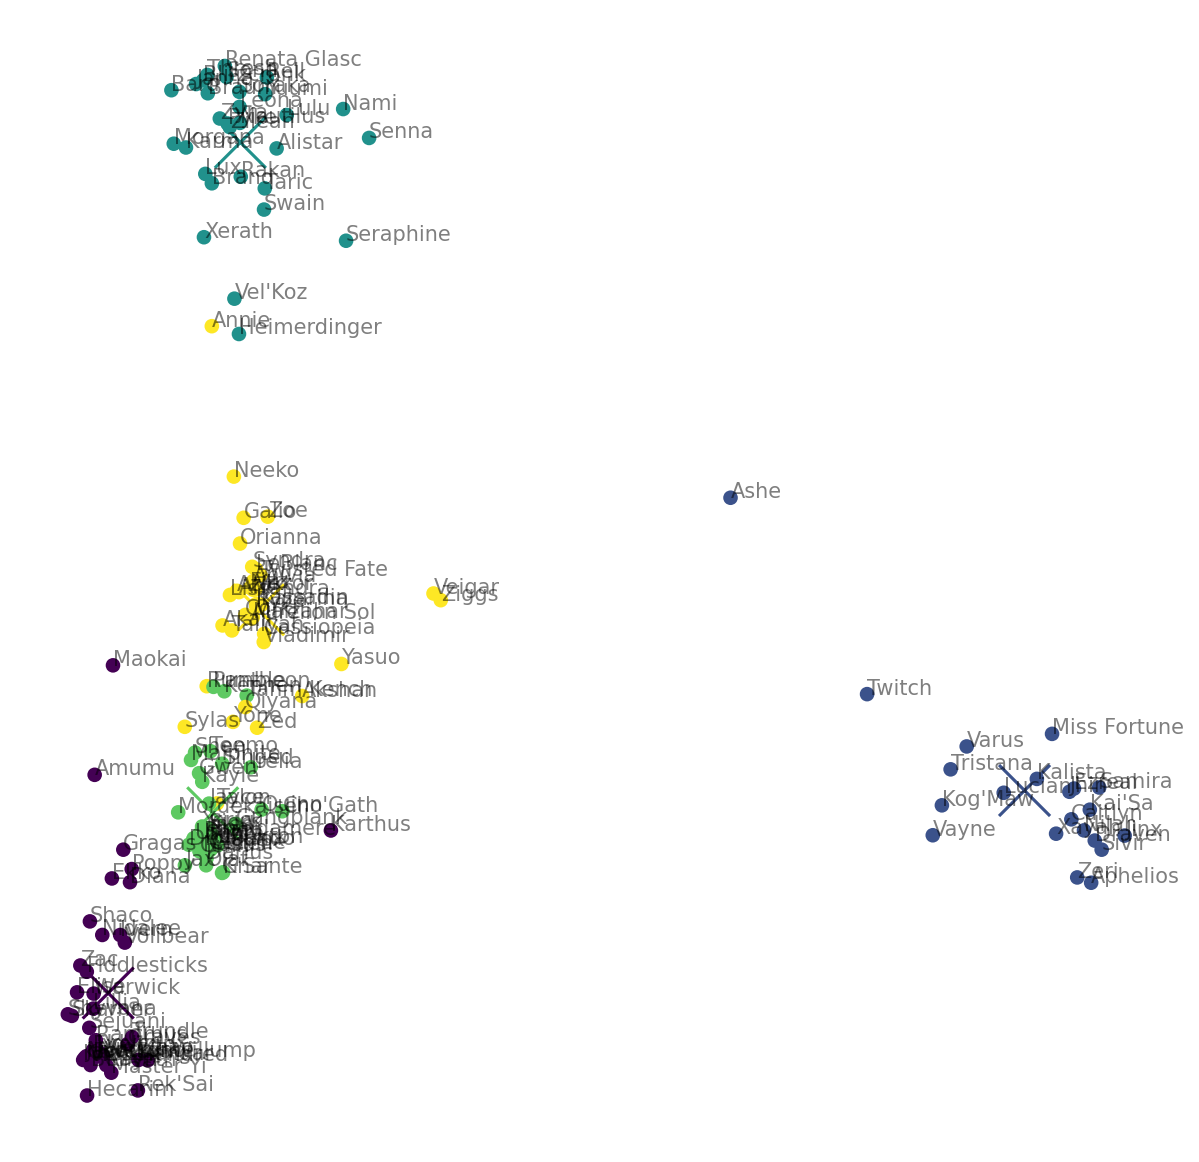

In [19]:
centers = clustering.cluster_centers_

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
centers_pca = pca.transform(centers)

fig, ax = plt.subplots(figsize=(10,10), dpi=150)
plt.axis("off")

plt.scatter(X_pca[:,0], X_pca[:,1], c=clustering.labels_)
for i, txt in enumerate(labels):
    ax.annotate(txt, (X_pca[i,0], X_pca[i,1]), alpha=0.5)

plt.scatter(centers_pca[:,0], centers_pca[:,1], c=range(centers.shape[0]), marker="x", s=600)

plt.savefig("showcase/pca.png")

In [20]:
by_clusters = defaultdict(list)

for cluster, label in zip(clustering.labels_, labels):
    by_clusters[cluster].append(label)

for k in sorted(by_clusters.keys()):
    print(k, by_clusters[k])


0 ['Xin Zhao', 'Fiddlesticks', 'Master Yi', 'Warwick', 'Nunu & Willump', 'Evelynn', 'Karthus', 'Amumu', 'Rammus', 'Shaco', 'Trundle', 'Nocturne', 'Maokai', 'Jarvan IV', 'Elise', 'Wukong', 'Lee Sin', 'Skarner', 'Nidalee', 'Udyr', 'Poppy', 'Gragas', 'Shyvana', 'Graves', 'Volibear', 'Rengar', 'Sejuani', 'Hecarim', "Kha'Zix", 'Diana', 'Kayn', 'Zac', "Bel'Veth", 'Kindred', 'Viego', 'Ekko', 'Vi', "Rek'Sai", 'Ivern', 'Lillia']
1 ['Sivir', 'Tristana', 'Miss Fortune', 'Ashe', 'Twitch', 'Caitlyn', 'Vayne', 'Ezreal', "Kog'Maw", 'Varus', 'Draven', "Kai'Sa", 'Jhin', 'Zeri', 'Jinx', 'Lucian', 'Samira', 'Kalista', 'Xayah', 'Aphelios', 'Nilah']
2 ['Alistar', 'Soraka', 'Morgana', 'Zilean', 'Sona', 'Janna', 'Karma', 'Taric', 'Swain', 'Blitzcrank', 'Brand', 'Heimerdinger', 'Leona', 'Lux', 'Xerath', 'Nautilus', 'Lulu', 'Zyra', 'Seraphine', "Vel'Koz", 'Braum', 'Senna', 'Nami', 'Yuumi', 'Thresh', 'Bard', 'Rakan', 'Rell', 'Pyke', 'Renata Glasc']
3 ['Olaf', 'Urgot', 'Kayle', 'Sion', 'Teemo', 'Tryndamere', 'Ja

## Manual cluster tagging

use the result above to manually tag the clusters

In [21]:
manual_cluster_tagging = {
    0: "jungle",
    1: "adc",
    2: "support",
    3: "top",
    4: "mid",
}

## Transform the cluster distance to center into a "similarity score"

In [22]:
Y = clustering.transform(X)
# add an exponent to clearly see the main positions
Y = (1 / (Y + 1)) ** 10
# normalize to 1
Y = Y / Y.sum(axis=1)[:,None]

for y, label in zip(Y, labels):
    print(y, label)

[0.08158929 0.02812822 0.32464537 0.10280519 0.46283192] Annie
[0.06250493 0.01722353 0.03118445 0.83156457 0.05752252] Olaf
[0.09128646 0.03355382 0.1185334  0.12432959 0.63229674] Galio
[0.07041631 0.03044804 0.07162596 0.10674936 0.72076033] Twisted Fate
[0.78638058 0.02174409 0.03906681 0.08771481 0.0650937 ] Xin Zhao
[0.07577458 0.02257761 0.04462441 0.78421022 0.07281319] Urgot
[0.04783712 0.0201389  0.04735162 0.06741078 0.81726158] LeBlanc
[0.05899157 0.0249869  0.04856809 0.11107331 0.75638014] Vladimir
[0.79142754 0.02104516 0.04689784 0.06556651 0.07506295] Fiddlesticks
[0.07294599 0.02176625 0.04647912 0.74182304 0.11698561] Kayle
[0.82608365 0.02026492 0.03374285 0.0654064  0.05450218] Master Yi
[0.0648517  0.03415549 0.75177863 0.07632054 0.07289365] Alistar
[0.06476742 0.02620017 0.05824846 0.10103181 0.74975213] Ryze
[0.05526238 0.01653276 0.0325245  0.83845071 0.05722965] Sion
[0.02549246 0.89314982 0.0212817  0.02999271 0.03008331] Sivir
[0.03907734 0.01888625 0.84217

In [23]:
champions_positions = []

for key, label, y in zip(champion_ids, labels, Y):
    positions = {}
    for i, yi in enumerate(y):
        positions[manual_cluster_tagging[i]] = float(yi)
    champions_positions.append({
        "label": str(label),
        "key": str(key),
        "positions": positions
    })

json.dump(champions_positions, open("data/champions_positions.json", "w"))
pprint(champions_positions)

[{'key': '1',
  'label': 'Annie',
  'positions': {'adc': 0.02812821797803184,
                'jungle': 0.08158929379823616,
                'mid': 0.4628319215436317,
                'support': 0.3246453717766965,
                'top': 0.10280519490340385}},
 {'key': '2',
  'label': 'Olaf',
  'positions': {'adc': 0.017223533320434067,
                'jungle': 0.06250492795425536,
                'mid': 0.05752252345087307,
                'support': 0.031184449295443072,
                'top': 0.8315645659789944}},
 {'key': '3',
  'label': 'Galio',
  'positions': {'adc': 0.03355381590159297,
                'jungle': 0.09128645995184557,
                'mid': 0.6322967362676374,
                'support': 0.1185333995962511,
                'top': 0.12432958828267292}},
 {'key': '4',
  'label': 'Twisted Fate',
  'positions': {'adc': 0.030448036541120438,
                'jungle': 0.07041631146521732,
                'mid': 0.7207603311105413,
                'support': 0.0716259593